In [2]:
# importation des packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import math
import cmocean as cmo


Importation des donnnées et des variables

In [3]:
data = "imerg_pr_201911_3h.nc4"

# creer une liste avec les différentes valeurs de temps,latitudes et longitudes
xrds = xr.open_dataset(data)
lat = xrds.coords['lat'].values
long = xrds.coords['lon'].values
time = xrds.coords['time'].values
precip_Novembre = xrds['precipitationCal']

# Importation des variables
villes = ["KualaLumpur", "Montréal", "Point Océan", "Baku"]

KualaLumpur = [3.1, 101.6]
Montreal = [45.5, -73.5]
Ocean = [5.0, 106]
Baku = [40.4 , -49.9]

Liste des Fonctions Utilisées pour faire l'analyse des précipitations

In [4]:
# analyse des précipitations
def analyse_precipitation (liste_precip):

    accum = sum(liste_precip)

# taux de précipitation maximale
    taux_max_precip = max(liste_precip)

    liste_precip_positif = []
    nb_periode_pluie = 0
    max_periode_consecutive = 0
    current_streak = 0

# nombre de période et max consécutif
    for element in liste_precip:
        if element > 0.0:
            liste_precip_positif.append(element)
            nb_periode_pluie += 1
            current_streak += 1
            max_periode_consecutive = max(max_periode_consecutive, current_streak)
        else:
            current_streak = 0

# fréquence de précipitation
    frequence = (len(liste_precip_positif)/len(liste_precip)) * 100
    heures_pluie_consecutive = max_periode_consecutive * 3

# précipitation moyenne
    precip_moyenne_toute = accum/len(liste_precip)
    precip_moyenne_positif = accum/len(liste_precip_positif)


    resultats = {
        "Accumulation total \n (mm/mois)": accum,
        "Nombre de période \n de pluie" : nb_periode_pluie,
        "Féquence de précipitation ": frequence,
        "Precipitation moyenne": precip_moyenne_toute,
        "Intensité de précipitation \n moyenne": precip_moyenne_positif,
        "taux de précipitation \n maximum (mm/3h) " : taux_max_precip,
        "Heures de pluie \n consécutive": heures_pluie_consecutive,

    }
    return resultats

# Nom de la ville + indice ( [0] = lat, [1] = lon )
def donnee_coord_grille( ville ):

    donnees_precip = precip_Novembre.sel ( lat =  min( lat, key=lambda x: abs(x - ville[0])),
                                           lon = min(long, key=lambda x: abs(x - ville[1] )))
    return donnees_precip


In [5]:
def coordonnee_50km (ville,distance_km):

    delta_lat = distance_km / 111.0
    delta_lon = distance_km / (111.0 * math.cos(math.radians(ville[0])))

    lat_N = ville[0] + delta_lat
    lon_N = ville[1]
    coord_nord = [lat_N, lon_N]

    lat_S = ville[0] - delta_lat
    lon_S = ville[1]
    coord_sud = [lat_S, lon_S]

    lat_E = ville[0]
    lon_E = ville[1] + delta_lon
    Coord_est = [lat_E, lon_E]

    lat_O = ville[0]
    lon_O = ville[1] - delta_lon
    Coord_ouest = [lat_O, lon_O]

    resultats_coordonnees = {
       "Coordonnée nord": coord_nord,
       "Coordonnée sud": coord_sud,
       "Coordonnée est": Coord_est,
       "Coordonnée ouest": Coord_ouest,

   }

    return resultats_coordonnees

# donne les valeurs de la précipitation pour les 4 coordonnées indice ([0]= Nord, [1] = Sud, [2] = Est, [3] = Ouest.
def donnee_50km(dictionnaire):

    Precip_50Km = []

    for value in dictionnaire.values():

        donnees_precip = precip_Novembre.sel ( lat =  min( lat, key=lambda x: abs(x - value[0])),
                                               lon = min(long, key=lambda x: abs(x - value[1] )),)

        Precip_50Km.append(donnees_precip.values)


    return Precip_50Km


Analyse des précipitations pour différentes villes

In [6]:
donnee_KL = donnee_coord_grille(KualaLumpur)
analyse_KL = analyse_precipitation(donnee_KL.values)


donnee_MTL = donnee_coord_grille(Montreal)
analyse_MTL =analyse_precipitation(donnee_MTL.values)

donnee_Ocean = donnee_coord_grille(Ocean)
analyse_Ocean = analyse_precipitation(donnee_Ocean.values)

donnee_Baku = donnee_coord_grille(Baku)
analyse_Baku = analyse_precipitation(donnee_Baku.values)


ensemble = [analyse_KL, analyse_MTL, analyse_Ocean, analyse_Baku]



Création du tableau pour l'analyse de la précipitation

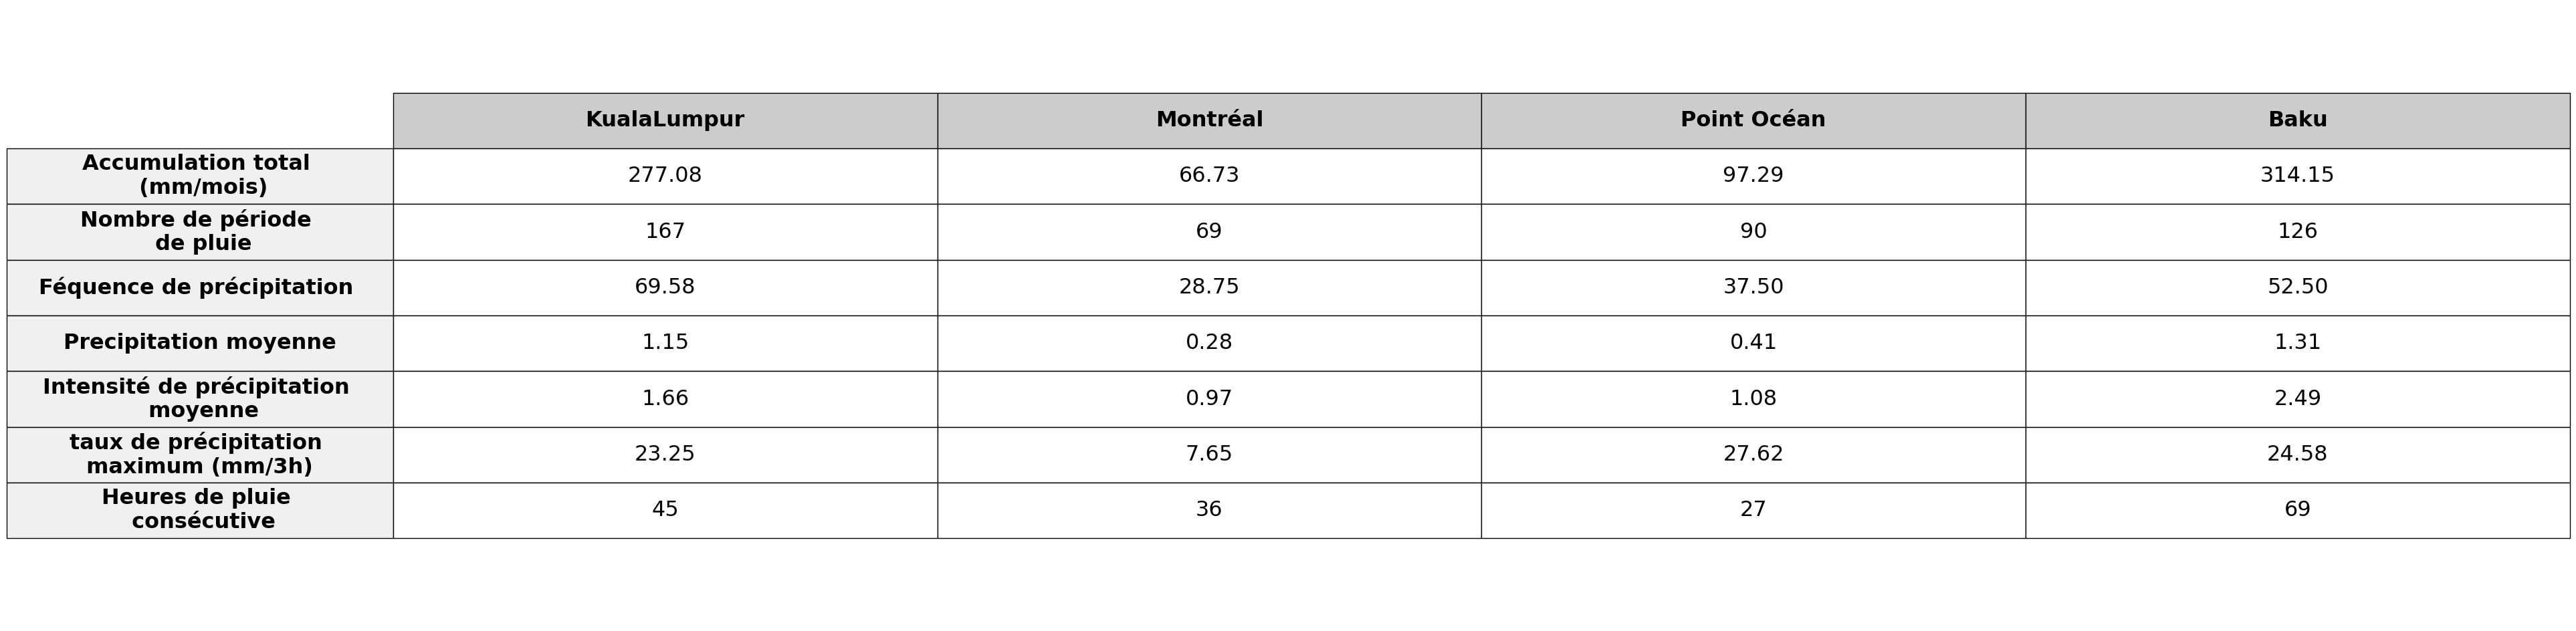

In [7]:
fig, ax = plt.subplots(figsize=(14, 12))
ax.axis("off")

# Colonnes = villes
colLabels = villes
# Lignes = catégories
rowLabels = list(ensemble[0].keys())

# Construire le tableau normal
cellText = []
for dico in ensemble:
    row = [f"{val:.2f}" if isinstance(val, (float, np.floating)) else val
           for val in dico.values()]
    cellText.append(row)

# Transposer pour avoir catégories en lignes
cellText_T = list(map(list, zip(*cellText)))

# Créer le tableau
table = ax.table(cellText=cellText_T,
                 rowLabels=rowLabels,
                 colLabels=colLabels,
                 cellLoc="center",
                 rowLoc="center",
                 loc="center")

# Améliorer style
table.auto_set_font_size(True)
table.set_fontsize(23)
table.scale(3, 5)

for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:
        cell.set_facecolor("#cccccc")
        cell.set_text_props(weight="bold")
    if col == -1:
        cell.set_facecolor("#f0f0f0")
        cell.set_text_props(weight="bold")

plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Tableau1.png", dpi=150, bbox_inches="tight")
plt.show()

Analyse de la corrélation à 50 Km (Nord,Sud,Est,Ouest)

In [8]:
voisin_KL = (donnee_50km(coordonnee_50km(KualaLumpur,50)))
voisin_MTL = (donnee_50km(coordonnee_50km(Montreal,50)))
voisin_Ocean = (donnee_50km(coordonnee_50km(Ocean,50)))
voisin_Baku = (donnee_50km(coordonnee_50km(Baku,50)))

def correlation_temp(donnee_KL,series_voisines):

    correlations = []

    for direction in series_voisines:
        corr_matrix = np.corrcoef(donnee_KL.values, direction)
        corr = corr_matrix[0, 1]
        correlations.append(corr)

    return correlations

directions = ['Nord','Sud','Est','Ouest']

corel_Kl = correlation_temp(donnee_KL,voisin_KL)
corel_MTL = correlation_temp(donnee_MTL,voisin_MTL)
corel_Ocean = correlation_temp(donnee_Ocean,voisin_Ocean)
corel_Baku = correlation_temp(donnee_Baku,voisin_Baku)


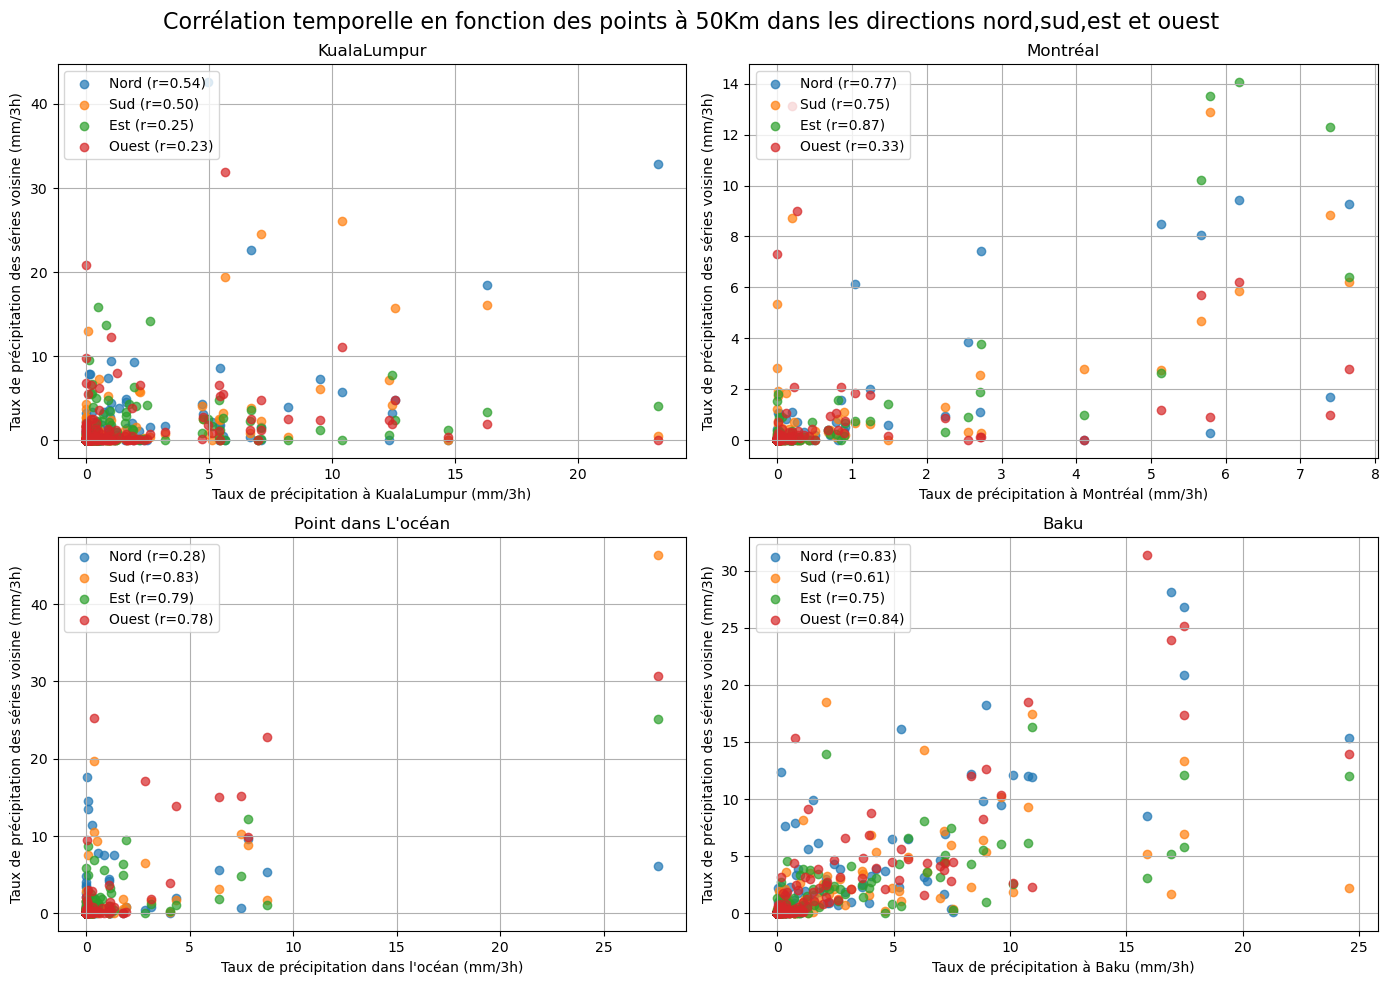

In [9]:
# construction des graphiques
fig,axs = plt.subplots(2,2, figsize=(14,10))

for i, direction in enumerate(voisin_KL):
    axs[0,0].scatter(donnee_KL.values, direction, label=f'{directions[i]} (r={corel_Kl[i]:.2f})', alpha=0.7)

axs[0,0].legend(loc="upper left")
axs[0,0].grid(True)
axs[0,0].set_xlabel('Taux de précipitation à KualaLumpur (mm/3h)')
axs[0,0].set_ylabel('Taux de précipitation des séries voisine (mm/3h)')
axs[0,0].set_title('KualaLumpur')

for i, direction in enumerate(voisin_MTL):
    axs[0,1].scatter(donnee_MTL.values, direction, label=f'{directions[i]} (r={corel_MTL[i]:.2f})', alpha=0.7)

axs[0,1].legend(loc="upper left")
axs[0,1].grid(True)
axs[0,1].set_xlabel('Taux de précipitation à Montréal (mm/3h)')
axs[0,1].set_ylabel('Taux de précipitation des séries voisine (mm/3h)')
axs[0,1].set_title('Montréal')

for i, direction in enumerate(voisin_Ocean):
    axs[1,0].scatter(donnee_Ocean.values, direction, label=f'{directions[i]} (r={corel_Ocean[i]:.2f})', alpha=0.7)

axs[1,0].legend(loc="upper left")
axs[1,0].grid(True)
axs[1,0].set_xlabel("Taux de précipitation dans l'océan (mm/3h)")
axs[1,0].set_ylabel('Taux de précipitation des séries voisine (mm/3h)')
axs[1,0].set_title("Point dans L'océan")

for i, direction in enumerate(voisin_Baku):
    axs[1,1].scatter(donnee_Baku.values, direction, label=f'{directions[i]} (r={corel_Baku[i]:.2f})', alpha=0.7)

axs[1,1].legend(loc="upper left")
axs[1,1].grid(True)
axs[1,1].set_xlabel('Taux de précipitation à Baku (mm/3h)')
axs[1,1].set_ylabel('Taux de précipitation des séries voisine (mm/3h)')
axs[1,1].set_title('Baku')



plt.suptitle("Corrélation temporelle en fonction des points à 50Km dans les directions nord,sud,est et ouest ", fontsize=16)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure1.png", dpi=300, bbox_inches="tight")
plt.show()

Taux de précipitation pour les 5 premiers jours de novembre

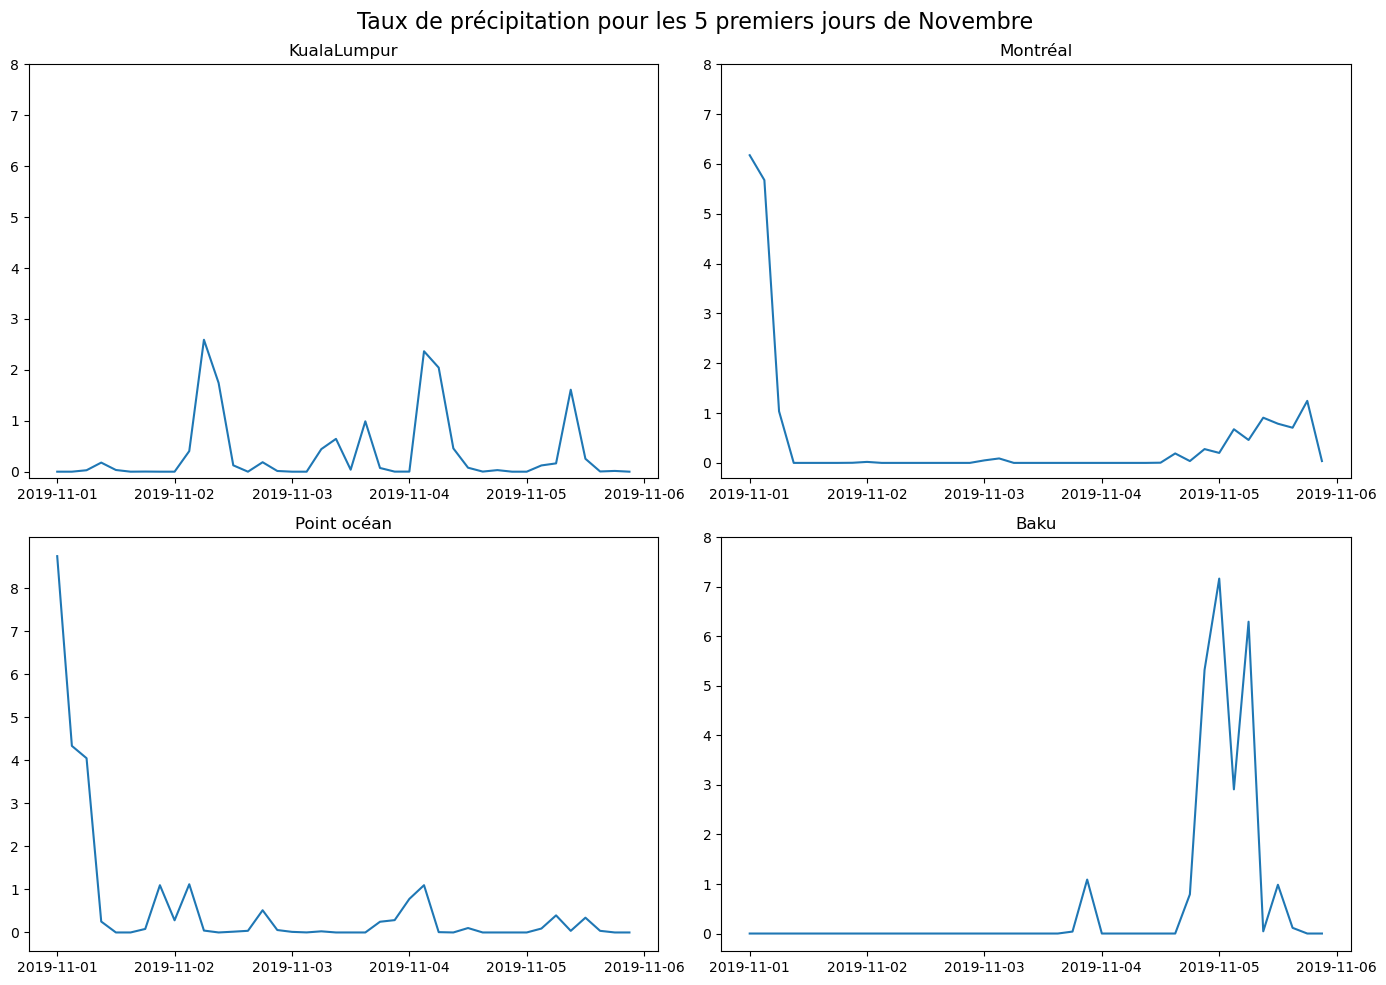

In [10]:
fig,axs = plt.subplots(2,2, figsize=(14,10))

axs[0,0].plot(time[0:40],donnee_KL.values[0:40])
axs[0,0].set_title("KualaLumpur")
axs[0,0].set_yticks((range(0, 9)))

axs[0,1].plot(time[0:40],donnee_MTL.values[0:40])
axs[0,1].set_title("Montréal")
axs[0,1].set_yticks((range(0, 9)))

axs[1,0].plot(time[0:40],donnee_Ocean.values[0:40])
axs[1,0].set_title("Point océan")
axs[1,0].set_yticks((range(0, 9)))

axs[1,1].plot(time[0:40],donnee_Baku.values[0:40])
axs[1,1].set_title("Baku")
axs[1,1].set_yticks((range(0, 9)))

fig.suptitle("Taux de précipitation pour les 5 premiers jours de Novembre", fontsize=16)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure2.png", dpi=300, bbox_inches="tight")
plt.show()

donnee_journ_KL = donnee_KL.values.reshape(-1,8)
moyenne = donnee_journ_KL.mean(axis=1)



Représentation du cycle journalier de précipitation

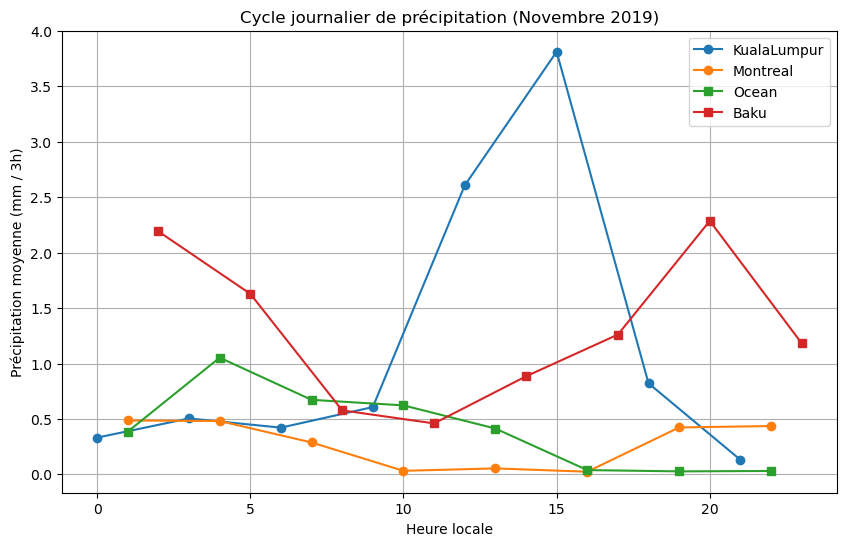

In [11]:
# convertion en heure local
def cycle_joun(donnee_KL, ville):
    time_offset = ville[1]/15.0
    time_utc = pd.to_datetime(donnee_KL.time.values)
    time_local = time_utc + pd.to_timedelta(time_offset, unit="h")
    precip_point = donnee_KL.assign_coords(time=("time", time_local))
    cycle = precip_point.groupby("time.hour").mean()

    return cycle


Cycle_KL = cycle_joun(donnee_KL, KualaLumpur)
Cycle_MTL = cycle_joun(donnee_MTL, Montreal)
Cycle_Ocean = cycle_joun(donnee_Ocean, Ocean)
Cycle_Baku = cycle_joun(donnee_Baku, Baku)

# création du graphique
plt.figure(figsize=(10,6))

plt.plot(Cycle_KL["hour"], Cycle_KL.values, marker="o", label='KualaLumpur')

plt.plot(Cycle_MTL["hour"], Cycle_MTL.values, marker="o", label='Montreal')

plt.plot(Cycle_Ocean["hour"], Cycle_Ocean.values, marker="s", label='Ocean')

plt.plot(Cycle_Baku["hour"], Cycle_Baku.values, marker="s", label='Baku')



plt.xlabel("Heure locale")
plt.ylabel("Précipitation moyenne (mm / 3h)")
plt.title("Cycle journalier de précipitation (Novembre 2019)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure3.png", dpi=300, bbox_inches="tight")
plt.show()

Fonctions pour les graphiques temporelles

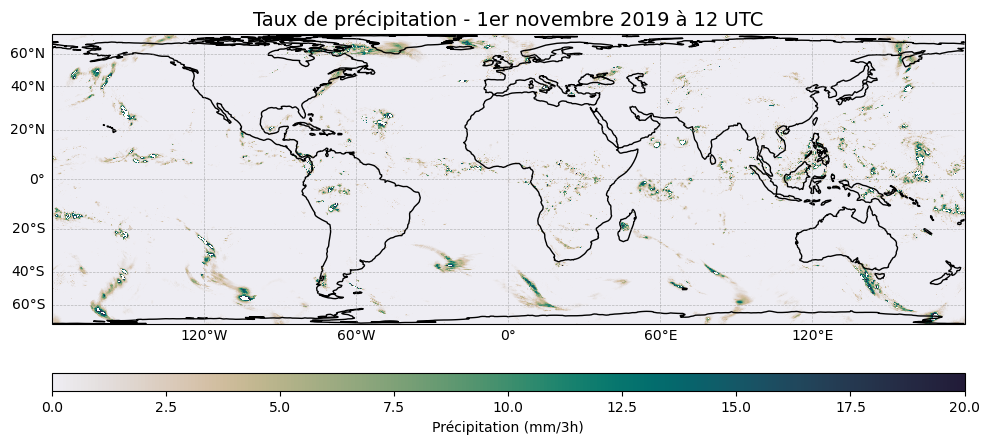

In [22]:
date_1ernov = '2019-11-01 12:00:00'

precip_1erNov = precip_Novembre.sel(time=date_1ernov)
precip_intervalle_1erNov = precip_1erNov.where((precip_1erNov >= 0) & (precip_1erNov <= 20))

# création du graphique
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.LambertCylindrical())

mesh = ax.pcolormesh(long,lat,precip_intervalle_1erNov,transform=ccrs.LambertCylindrical(),cmap='cmo.rain',vmin = 0, vmax = 20)

# ajour de la carte de fond et ajustement
ax.coastlines()
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# ajout de la colorcar
cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")


plt.title("Taux de précipitation - 1er novembre 2019 à 12 UTC", fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure4.png", dpi=300, bbox_inches="tight")
plt.show()


Histogramme du nombre de valeur de précipitation par intensité

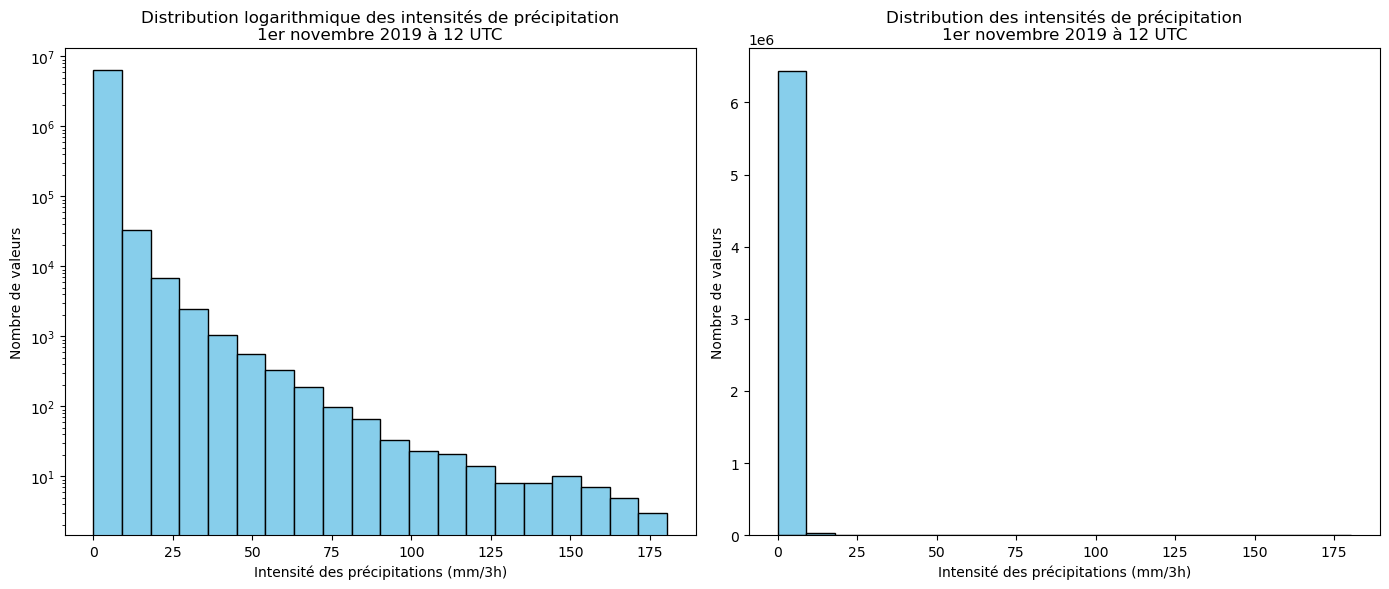

In [13]:
# définir les limites
max_precip_1erNov = precip_1erNov.values.flatten().max()
bins = np.linspace(0, max_precip_1erNov, 21)

# création des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# histogramme logarithmique
axs[0].hist(precip_1erNov.values.flatten(), bins=bins, edgecolor='black',
            log=True, color='skyblue')
axs[0].set_xlabel("Intensité des précipitations (mm/3h)")
axs[0].set_ylabel("Nombre de valeurs")
axs[0].set_title("Distribution logarithmique des intensités de précipitation\n1er novembre 2019 à 12 UTC")

# histogramme normal
axs[1].hist(precip_1erNov.values.flatten(), bins=bins, edgecolor='black',
            log=False, color='skyblue')
axs[1].set_xlabel("Intensité des précipitations (mm/3h)")
axs[1].set_ylabel("Nombre de valeurs")
axs[1].set_title("Distribution des intensités de précipitation\n1er novembre 2019 à 12 UTC")

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure5.png",
            dpi=300, bbox_inches="tight")
plt.show()

Carte du taux de précipitation moyenné sur le mois

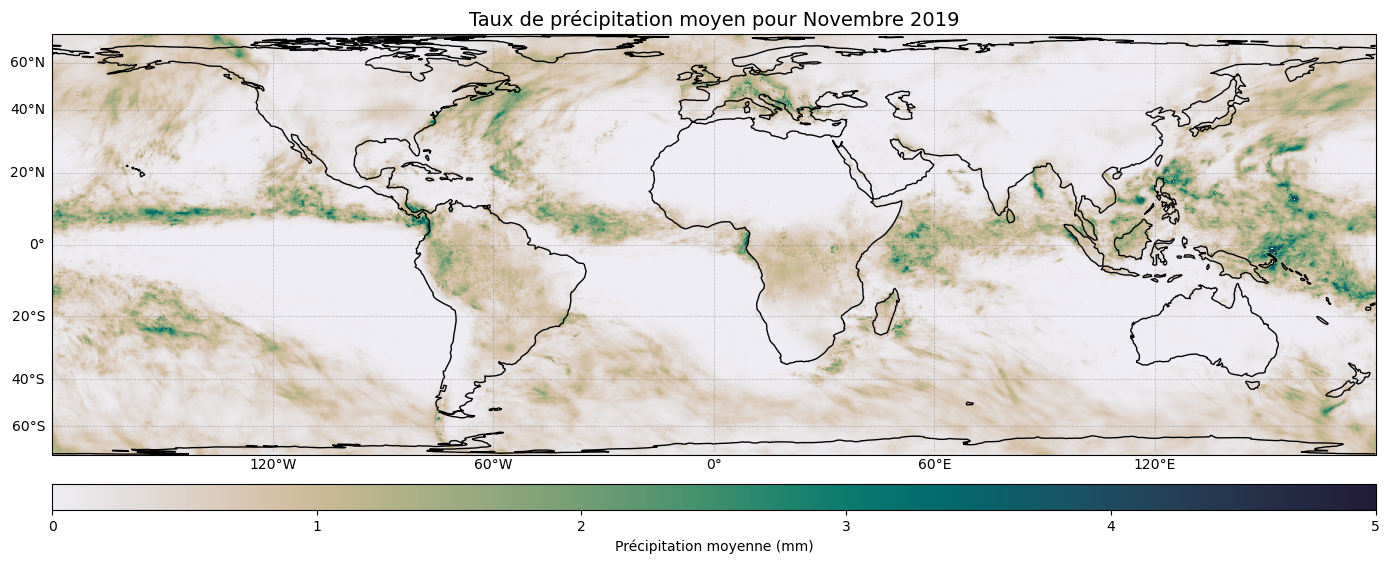

In [21]:
precip_moyenne_Novembre = precip_Novembre.mean(dim='time')
precip_moyenne_intervelle = precip_moyenne_Novembre.where(
    (precip_moyenne_Novembre >= 0) &
    (precip_moyenne_Novembre <= 5))

# Faire le graphique
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.LambertCylindrical())

mesh = ax.pcolormesh(
    long, lat, precip_moyenne_intervelle,
    transform=ccrs.LambertCylindrical(),
    cmap='cmo.rain',

    vmin=0, vmax=5

)

# afficher la carte et ajuster la grille
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# création de la barre de couleur et du titre
cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Précipitation moyenne (mm)")
plt.title("Taux de précipitation moyen pour Novembre 2019", fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure6.png", dpi=300, bbox_inches="tight")
plt.show()

Histogramme du taux moyenné sur le mois

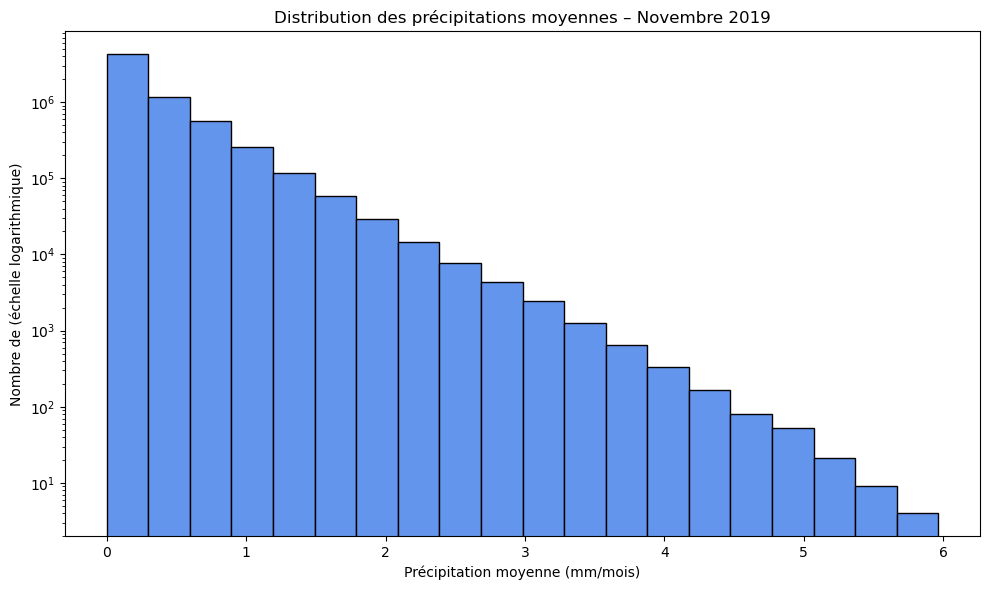

In [15]:
# Définir les limites
max_val = precip_moyenne_Novembre.values.flatten().max()
bins = np.linspace(0, max_val, 21)  # 20 classes

# Faire le graphique
plt.figure(figsize=(10, 6))
plt.hist(precip_moyenne_Novembre.values.flatten(), bins=bins, edgecolor='black', log=True, color='cornflowerblue')

# Nom des axes
plt.xlabel("Précipitation moyenne (mm/mois)")
plt.ylabel("Nombre de (échelle logarithmique)")
plt.title("Distribution des précipitations moyennes – Novembre 2019")


plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure7.png", dpi=300, bbox_inches="tight")
plt.show()

Figure bonus : Moyenne de précipitation en fonction de la latitude

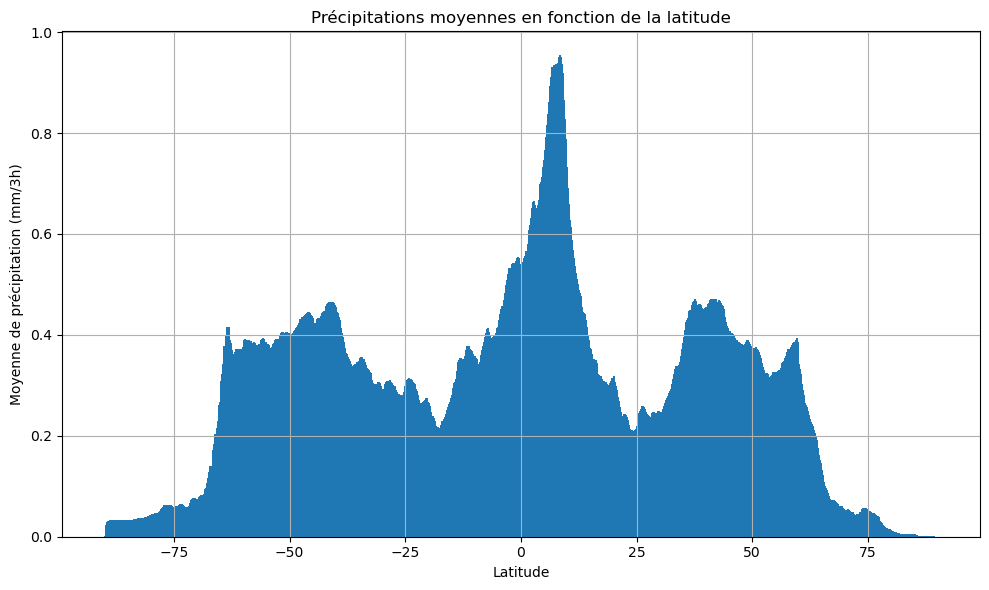

In [16]:
# Faire le graphique
precip_bonus = precip_Novembre.mean(dim =[ 'time','lon'])

plt.figure(figsize=(10, 6))
plt.bar(lat,precip_bonus,width=0.5)

# Nom des axes
plt.xlabel("Latitude")
plt.ylabel("Moyenne de précipitation (mm/3h)")
plt.title("Précipitations moyennes en fonction de la latitude")

plt.grid(True)
plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/FigureBonus.png", dpi=300, bbox_inches="tight")
plt.show()

Zoom sur Montréal avec pcolormesh

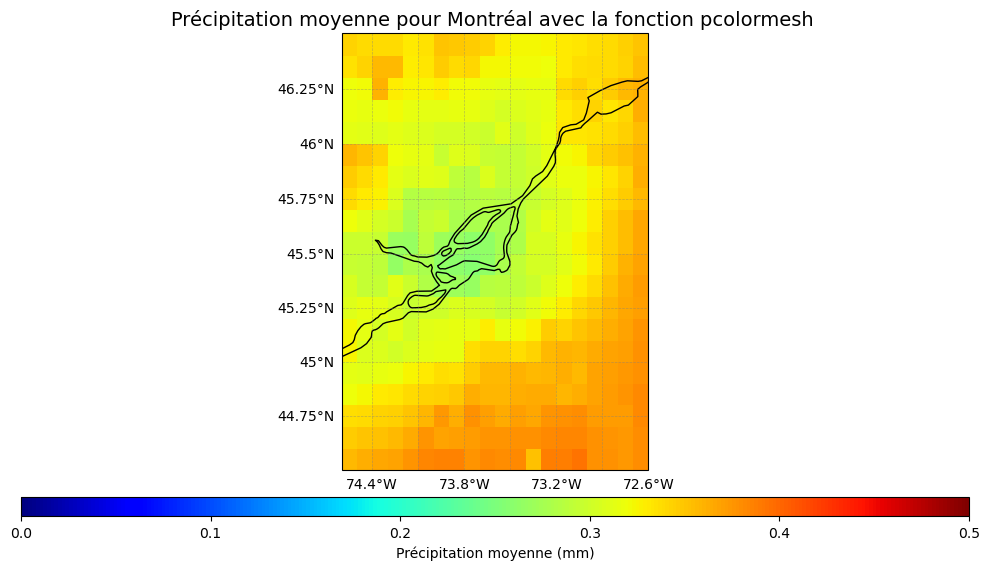

In [19]:
# région de Montréal (Mettre en haut avec les données utiles)
lat_region_Montreal = slice(44.5017, 46.5017)
lon_region_montreal = slice(-74.5673, -72.5673)

# Données de précip pour la région voulue
precip_Montreal = precip_moyenne_Novembre.sel( lat = lat_region_Montreal,
                                               lon = lon_region_montreal )

# Coordonnée dans le imerg pour tracer les données
lat_mtl = precip_Montreal ['lat']
lon_mtl = precip_Montreal ['lon']

# Faire le graphique
fig = plt.figure( figsize = (10, 6) )
ax = plt.axes( projection = ccrs.Mercator() )

mesh = ax.pcolormesh( lon_mtl, lat_mtl, precip_Montreal,
    transform = ccrs.PlateCarree(),
    cmap = 'jet',
    vmin = 0, vmax = 0.5)

# Afficher le fond de carte et ajuster la grille
ax.coastlines()
gl = ax.gridlines(draw_labels=True,
                  linewidth = 0.5,
                  color='gray',
                  alpha = 0.5,
                  linestyle ='--')

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Ajouter la barre de couleur et titre
cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Précipitation moyenne (mm)")

plt.title("Précipitation moyenne pour Montréal avec la fonction pcolormesh ", fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure8.png", dpi=300, bbox_inches="tight")
plt.show()


Zoom sur Montréal avec contourf

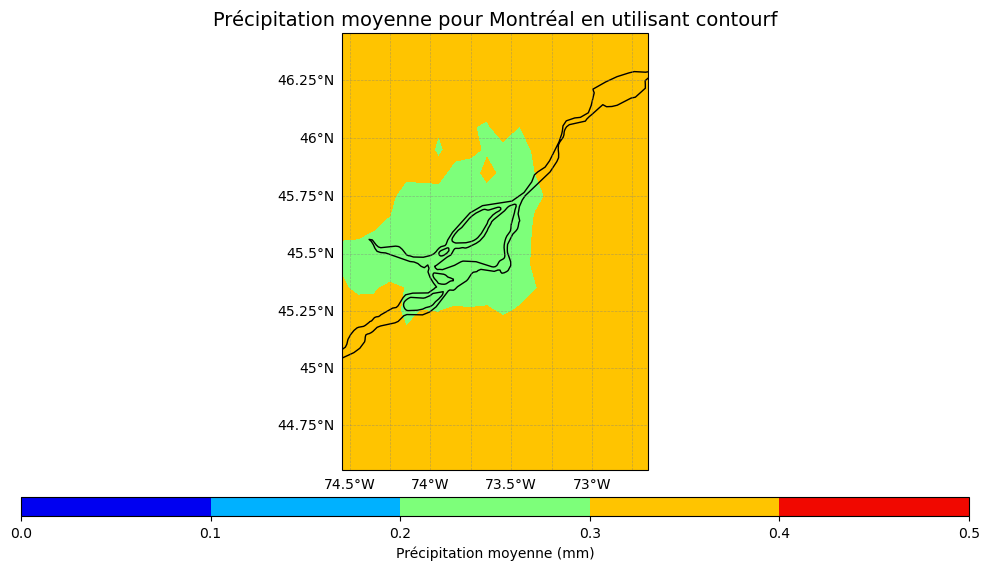

In [20]:

# Faire le graphique
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())

levels = np.linspace(0.0, 0.5, 6)

contour = ax.contourf( lon_mtl, lat_mtl, precip_Montreal,
    transform = ccrs.PlateCarree(),
    cmap = 'jet',
    levels = levels)

# Afficher le fond de carte et ajuster la grille
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Ajouter la barre de couleur et titre
cbar = plt.colorbar(contour, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Précipitation moyenne (mm)")
plt.title("Précipitation moyenne pour Montréal en utilisant contourf", fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/samue/Desktop/université/3e année/5e session (automne 2025)/Laboratoire 3/Expérience 1/Figure9.png", dpi=300, bbox_inches="tight")
plt.show()